## Лабораторная работа №2: "Обработка признаков (часть 1)"
### ИУ5-21 Курганова Александра

#### Задание:
Выбрать набор данных (датасет), содержащий категориальные и числовые признаки и пропуски в данных. 

Для выполнения следующих пунктов можно использовать несколько различных наборов данных

Для выбранного датасета (датасетов) на основе материалов лекций решить следующие задачи:
*   устранение пропусков в данных;
*   кодирование категориальных признаков;
*   нормализацию числовых признаков.



In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = "/content/drive/My Drive/Colab Notebooks/ммо/lr2"

Mounted at /content/drive


In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from IPython.display import Image
import scipy.stats as stats
%matplotlib inline 
sns.set(style="ticks")

#### Информация о датасете

In [3]:
dataset1 = pd.read_csv(path+'/heroes_information.csv')

In [4]:
dataset1.head()

,Unnamed: 0,name,Gender,Eye color,Race,Hair color,Height,Publisher,Skin color,Alignment,Weight
0,0,A-Bomb,Male,yellow,Human,No Hair,203.0,Marvel Comics,-,good,441.0
1,1,Abe Sapien,Male,blue,Icthyo Sapien,No Hair,191.0,Dark Horse Comics,blue,good,65.0
2,2,Abin Sur,Male,blue,Ungaran,No Hair,185.0,DC Comics,red,good,90.0
3,3,Abomination,Male,green,Human / Radiation,No Hair,203.0,Marvel Comics,-,bad,441.0
4,4,Abraxas,Male,blue,Cosmic Entity,Black,-99.0,Marvel Comics,-,bad,-99.0


In [46]:
dataset1.shape

(734, 11)

In [47]:
data_features1 = list(zip(
# признаки
[i for i in dataset1.columns],
zip(
    # типы колонок
    [str(i) for i in dataset1.dtypes],
    # проверим есть ли пропущенные значения
    [i for i in dataset1.isnull().sum()]
)))
# Признаки с типом данных и количеством пропусков
data_features1

[('Unnamed: 0', ('int64', 0)),
 ('name', ('object', 0)),
 ('Gender', ('object', 0)),
 ('Eye color', ('object', 0)),
 ('Race', ('object', 0)),
 ('Hair color', ('object', 0)),
 ('Height', ('float64', 0)),
 ('Publisher', ('object', 15)),
 ('Skin color', ('object', 0)),
 ('Alignment', ('object', 0)),
 ('Weight', ('float64', 2))]

In [48]:
# Колонки с пропусками
columns_with_na = [c for c in dataset1.columns if dataset1[c].isnull().sum() > 0]
data1_cat_new = dataset1[columns_with_na].copy() 

In [49]:
# % пропусков
[(c, dataset1[c].isnull().mean()) for c in columns_with_na]

[('Publisher', 0.020435967302452316), ('Weight', 0.0027247956403269754)]

In [50]:
filtered_columns1 = ['name', 'Race', 'Publisher', 'Weight']
data1 = dataset1[filtered_columns1]
data1.head()

,name,Race,Publisher,Weight
0,A-Bomb,Human,Marvel Comics,441.0
1,Abe Sapien,Icthyo Sapien,Dark Horse Comics,65.0
2,Abin Sur,Ungaran,DC Comics,90.0
3,Abomination,Human / Radiation,Marvel Comics,441.0
4,Abraxas,Cosmic Entity,Marvel Comics,-99.0


#### Заполнение колонки Weight:

In [51]:
def impute_column(dataset, column, strategy_param, fill_value_param=None):
    temp_data = dataset[[column]].values
    size = temp_data.shape[0]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imputer = SimpleImputer(strategy=strategy_param, 
                            fill_value=fill_value_param)
    all_data = imputer.fit_transform(temp_data)
    
    missed_data = temp_data[mask_missing_values_only]
    filled_data = all_data[mask_missing_values_only]
    
    return all_data.reshape((size,)), filled_data, missed_data

In [52]:
all_data, filled_data, missed_data = impute_column(dataset1, 'Weight', 'mean')
all_data

array([441.        ,  65.        ,  90.        , 441.        ,
       -99.        , 122.        , -99.        ,  88.        ,
        61.        ,  81.        , 104.        , 108.        ,
        90.        ,  90.        , -99.        , -99.        ,
        72.        , 169.        , -99.        , 173.        ,
       101.        , -99.        ,  68.        , -99.        ,
        57.        ,  54.        , -99.        ,  83.        ,
        90.        , 122.        ,  86.        , -99.        ,
       -99.        , 358.        , 135.        , -99.        ,
       106.        , 146.        ,  63.        ,  68.        ,
        57.        ,  98.        , 270.        ,  59.        ,
        50.        , -99.        , -99.        , 101.        ,
       126.        ,  68.        , -99.        ,  54.        ,
        81.        , -99.        ,  72.        ,  63.        ,
        67.        , -99.        , -99.        , 180.        ,
        77.        ,  54.        , -99.        ,  57.  

In [53]:
filled_data

array([43.85519126, 43.85519126])

In [54]:
missed_data

array([nan, nan])

#### Заполнение колонки Publisher:

In [55]:
Publisher_cat_new_temp, _, _ = impute_column(data1_cat_new, 'Publisher', 'most_frequent')

In [56]:
data1_cat_new['Publisher'] = Publisher_cat_new_temp

In [78]:
def plot_hist_diff(old_ds, new_ds, cols):
    for c in cols:   
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.title.set_text('Поле - ' + str(c))
        old_ds[c].hist(bins=50, ax=ax, density=True, color='green')
        new_ds[c].hist(bins=50, ax=ax, color='blue', density=True, alpha=0.5)
        plt.show()

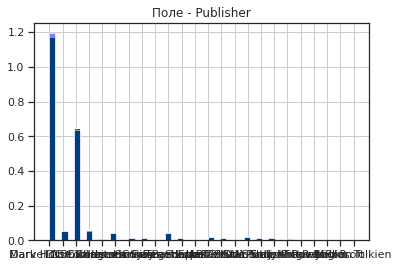

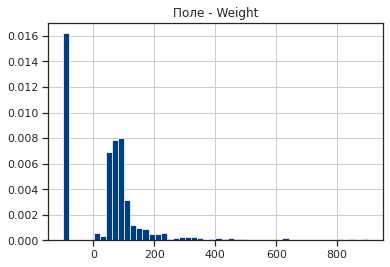

In [84]:
my_data = plot_hist_diff(dataset1, data1_cat_new, columns_with_na)

#### Кодирование категориальных признаков (InternetService)

In [19]:
dataset2 = pd.read_csv(path+'/telecom_users.csv')

In [20]:
dataset2.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No


In [21]:
dataset2.shape

(5986, 22)

In [22]:
data_features2 = list(zip(
# признаки
[i for i in dataset2.columns],
zip(
    # типы колонок
    [str(i) for i in dataset2.dtypes],
    # проверим есть ли пропущенные значения
    [i for i in dataset2.isnull().sum()]
)))
# Признаки с типом данных и количеством пропусков
data_features2

[('Unnamed: 0', ('int64', 0)),
 ('customerID', ('object', 0)),
 ('gender', ('object', 0)),
 ('SeniorCitizen', ('int64', 0)),
 ('Partner', ('object', 0)),
 ('Dependents', ('object', 0)),
 ('tenure', ('int64', 0)),
 ('PhoneService', ('object', 0)),
 ('MultipleLines', ('object', 0)),
 ('InternetService', ('object', 0)),
 ('OnlineSecurity', ('object', 0)),
 ('OnlineBackup', ('object', 0)),
 ('DeviceProtection', ('object', 0)),
 ('TechSupport', ('object', 0)),
 ('StreamingTV', ('object', 0)),
 ('StreamingMovies', ('object', 0)),
 ('Contract', ('object', 0)),
 ('PaperlessBilling', ('object', 0)),
 ('PaymentMethod', ('object', 0)),
 ('MonthlyCharges', ('float64', 0)),
 ('TotalCharges', ('object', 0)),
 ('Churn', ('object', 0))]

In [23]:
filtered_columns2 = ['SeniorCitizen', 'gender', 'tenure', 'InternetService', 'Contract', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']
data2 = dataset2[filtered_columns2]
data2.head()

,SeniorCitizen,gender,tenure,InternetService,Contract,PaymentMethod,MonthlyCharges,TotalCharges
0,0,Male,72,No,Two year,Credit card (automatic),24.10,1734.65
1,0,Female,44,Fiber optic,Month-to-month,Credit card (automatic),88.15,3973.2
2,1,Female,38,Fiber optic,Month-to-month,Bank transfer (automatic),74.95,2869.85
3,0,Male,4,DSL,Month-to-month,Electronic check,55.90,238.5
4,0,Male,2,DSL,Month-to-month,Electronic check,53.45,119.5


In [24]:
!pip install category_encoders
from category_encoders.woe import WOEEncoder as ce_WOEEncoder

     |████████████████████████████████| 81kB 3.6MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [28]:
ce_WOEEncoder1 = ce_WOEEncoder()
data_WOE_ENC = ce_WOEEncoder1.fit_transform(data2[data2.columns.difference(['SeniorCitizen'])], data2['SeniorCitizen'])

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [29]:
data2['InternetService'].unique()

array(['No', 'Fiber optic', 'DSL'], dtype=object)

In [30]:
data_WOE_ENC['InternetService'].unique()

array([-1.74767744,  0.64238762, -0.47283042])

In [33]:
def check_woe_encoding(field):
    data_ones = data2[data2['SeniorCitizen'] == 1].shape[0]
    data_zeros = data2[data2['SeniorCitizen'] == 0].shape[0]
    
    for s in data2[field].unique():
        data_filter = data2[data2[field]==s]
        if data_filter.shape[0] > 0:
            
            filter_data_ones = data_filter[data_filter['SeniorCitizen'] == 1].shape[0]
            filter_data_zeros = data_filter[data_filter['SeniorCitizen'] == 0].shape[0]

            good = filter_data_ones / data_ones
            bad = filter_data_zeros / data_zeros
            
            woe = np.log(good/bad)
            print(s, '-' , woe)

In [34]:
check_woe_encoding('InternetService')

No - -1.769305385118782
Fiber optic - 0.6431579890425195
DSL - -0.47513390020823026


#### Нормализация числовых признаков

In [74]:
data3 = pd.read_csv(path+'/Video_Games_Sales.csv', decimal=".")

In [75]:
data3.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(15,6))
    # гистограмма
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

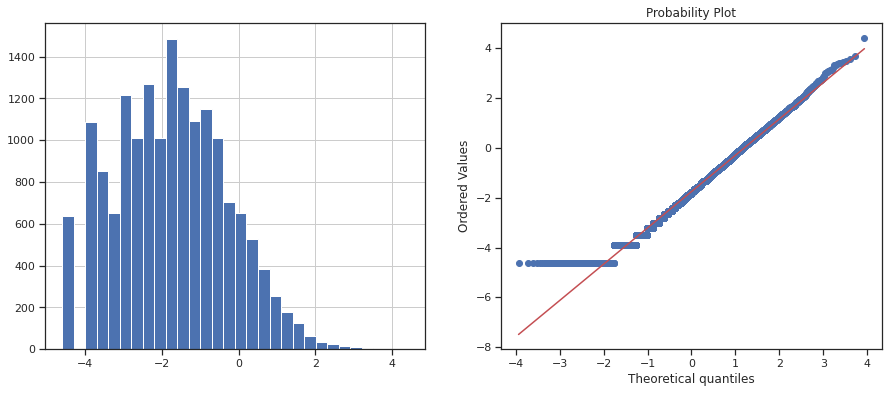

In [87]:
data3['Global_Sales_log'] = np.log(data3['Global_Sales'])
diagnostic_plots(data3, 'Global_Sales_log')